In [59]:
import glob
import sep
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import numpy as np
import astroalign as aa
from astropy.io import fits
from astroquery.ipac.irsa import Irsa
from astroquery.sdss import SDSS
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm, TABLEAU_COLORS
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, ApertureStats
from regions import CirclePixelRegion, PixCoord
from photutils import centroids

#imports
#FOR ASTROQUERRY: If you encounter an error related to "fields" in "SDSS.querry_crossid", try installing the newest development version of astroquerry rather than the default. There is a bug in the older official release version.

In [60]:
#just want to initialize all the data here
def lin_model(p, x): #We need this for ODR later.
    return p[0] * x + p[1]


class Data_Set:
    def ready_frames(self):
        night_dir = sorted(glob.glob(self.path + "/*"))
        opened = [fits.open(file) for file in night_dir]
        self.image_data = [file[1].data for file in opened]
        self.headers = [frame[1].header for frame in opened] #keep all headers
        self.wcs = WCS(self.headers[0]) #wcs should be the same for each set
        self.obs_filter = self.headers[0]['FILTER'][0]
        self.set_length = len(self.image_data)
        self.readout_noise = self.headers[0]['RDNOISE']

    def align_frames(self):
        try:
            aligned_frames = [aa.register(frame, self.image_data[0])[0] for frame in self.image_data[0:]]
            print("Frames aligned successfully.")
        except:
            aligned_frames = self.image_data
            raise UserWarning("AstroAlign could not align the image data")
        self.aligned_images = aligned_frames

    def combine(self):
        try:
            self.template = np.median(self.aligned_images, axis = 0)
        except:
            raise UserWarning("Please run self.align_frames() before combining")

    def extract_sources(self):
        bkg_phot_class = sep.Background(self.template) #background subtract for source extraction.
        self.references = sep.extract(self.template - bkg_phot_class.back(),  bkg_phot.globalrms*3, minarea =25, segmentation_map=False)

    def generate_calibration_individual(self, source_list, threshold):
        cal_params = []
        for count in range(len(self.aligned_images)*self.obs_night, len(self.aligned_images)*(1+self.obs_night)):

            inst_mags = [source.instrumental_mags[count] for source in source_list if source.is_reference == True and source.reference_mag < threshold and source.bad_source_flag == False]
            inst_mag_errs = [source.instrumental_mag_errs[count] for source in source_list if source.is_reference == True and source.reference_mag < threshold and source.bad_source_flag == False]

            sky_mags = [source.reference_mag[0] for source in source_list if source.is_reference == True and source.reference_mag < threshold and source.bad_source_flag == False]
            sky_mags_errs = [source.reference_mag_err[0] for source in source_list if source.is_reference == True and source.reference_mag < threshold and source.bad_source_flag == False ]

            linear = odr.Model(lin_model)
            calibration_data = odr.Data(inst_mags, sky_mags, we=inst_mag_errs, wd = sky_mags_errs)
            fit_params = odr.ODR(calibration_data, linear, beta0=[1.0, 23.5]).run() #beta0 is initial guesses
            cal_params.append(fit_params.beta)
        return cal_params

    def __init__(self, path, set_number):
        print(path)
        self.path = path
        self.obs_night = set_number
        self.image_data = None
        self.headers = None
        self.wcs = None
        self.obs_filter = None
        self.set_length = None
        self.readout_noise = None
        self.aligned_images = None
        self.template = None
        self.references = None
        self.calibration_parameters = []

In [61]:
files = sorted(glob.glob("/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/*")) #filepath for multi, this is a directory containing directories.


##### Class Version #####
Sets = [Data_Set(directory, run_number) for run_number, directory in enumerate(files)] #initialize the sets
total_frames = 0
for i, night in enumerate(Sets):
    night.ready_frames() #opens files, pulls image and header data for use
    night.align_frames() #tries to align frames
    night.combine() #makes median template
    night.extract_sources() #extracts sources
    total_frames += len(night.image_data) #running total on number of frames

#### Class Version ####


/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_02r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_03r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_06r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_07r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_08r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_09r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_10r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_11r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_12r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_13r
Frames aligned successfully.
Frames aligned successfully.
Frames aligned successfully.
Frames aligned successfully.
Frames aligned successfully.
Frames aligned successfully.
Frames aligned successfully.
Frames aligned successfully.
Frames aligned successfully.

In [62]:


#### Dict Version ####
data = []
for i, dr in enumerate(files):
    entry = dict(images = None, header = None, template = None, refs = None, WCS = None, run = i, directory = None) #dictionary object used to sort input files
    images = sorted(glob.glob(dr +'/*')) # formatting
    print(dr)
    hdus = [fits.open(i) for i in images] #opens fits files
    frames = [h[1].data for h in hdus] #image data
    header = (hdus[0])[1].header #the header for each run is the header for the first image, you don't need each individual header.
    try: #some datsets won't align, this is not ideal but we can skip alignment.
        aligned = [aa.register(i, frames[0])[0] for i in frames[0:]] #align takes quite a while, is there a way to make it faster?
    except:
        aligned = frames
        raise UserWarning("DID NOT ALIGN")

    template = np.median(aligned, axis = 0) #creates median value template
    w = WCS(hdus[0][1].header) #WCS matrix object, used to transform pixel values to RA-DEC coordinates
    #Fills out set object
    entry['images'] = aligned
    entry['header'] = header
    entry['template'] = template
    entry['WCS'] = w
    bkg_phot = sep.Background(template) #background subtract for source extraction.
    entry['refs'] = sep.extract(template - bkg_phot.back(),  bkg_phot.globalrms*3, minarea =25, segmentation_map=False) #find sources in image
     #this ensures that the source list is the same for all sets
    entry['run'] = i
    entry['directory'] = dr
    print(len(entry['refs'])) #check
    data.append(entry)

#### Dict Version ####

<class 'str'>
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_02r
81
<class 'str'>
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_03r
71
<class 'str'>
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_06r
64
<class 'str'>
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_07r
71
<class 'str'>
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_08r
69
<class 'str'>
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_09r
63
<class 'str'>
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_10r
71
<class 'str'>
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_11r
90
<class 'str'>
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_12r
70
<class 'str'>
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_13r
83


Class version: 10 nights. Dict version: 10 nights
<class 'numpy.dtype[float32]'> <class 'numpy.dtype[float32]'>
<class 'numpy.dtype[float32]'> <class 'numpy.dtype[float32]'>
<class 'numpy.dtype[float32]'> <class 'numpy.dtype[float32]'>
<class 'numpy.dtype[float32]'> <class 'numpy.dtype[float32]'>
<class 'numpy.dtype[float32]'> <class 'numpy.dtype[float32]'>
<class 'numpy.dtype[float32]'> <class 'numpy.dtype[float32]'>
<class 'numpy.dtype[float32]'> <class 'numpy.dtype[float32]'>
-0.00061833183 616.94434 -4710.9688


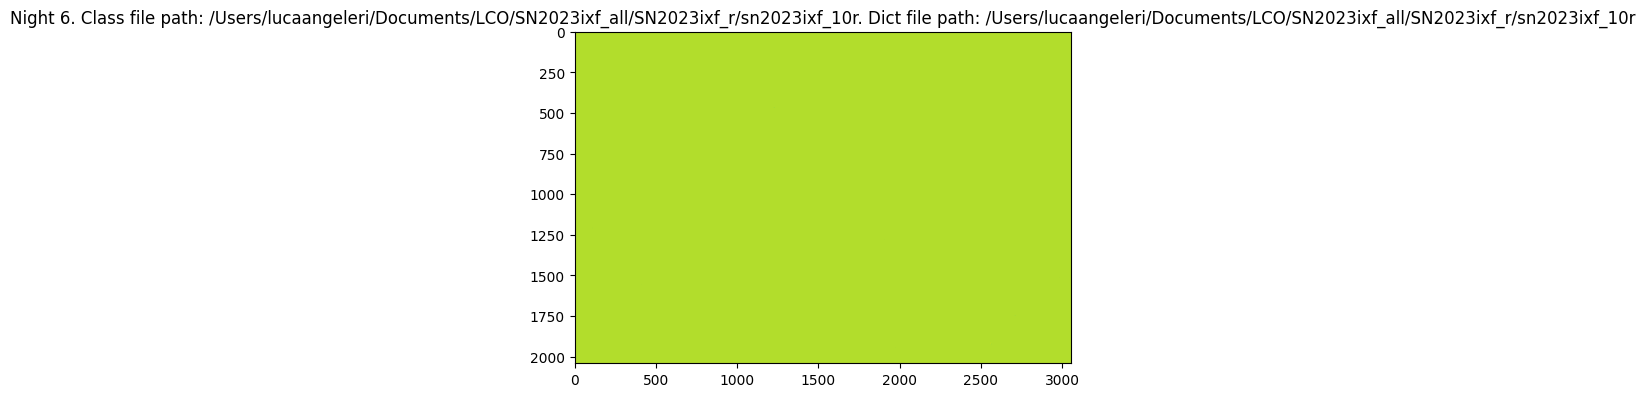

<class 'numpy.dtype[float32]'> <class 'numpy.dtype[float32]'>
<class 'numpy.dtype[float32]'> <class 'numpy.dtype[float32]'>
-2.2931315e-05 1129.9297 -879.874


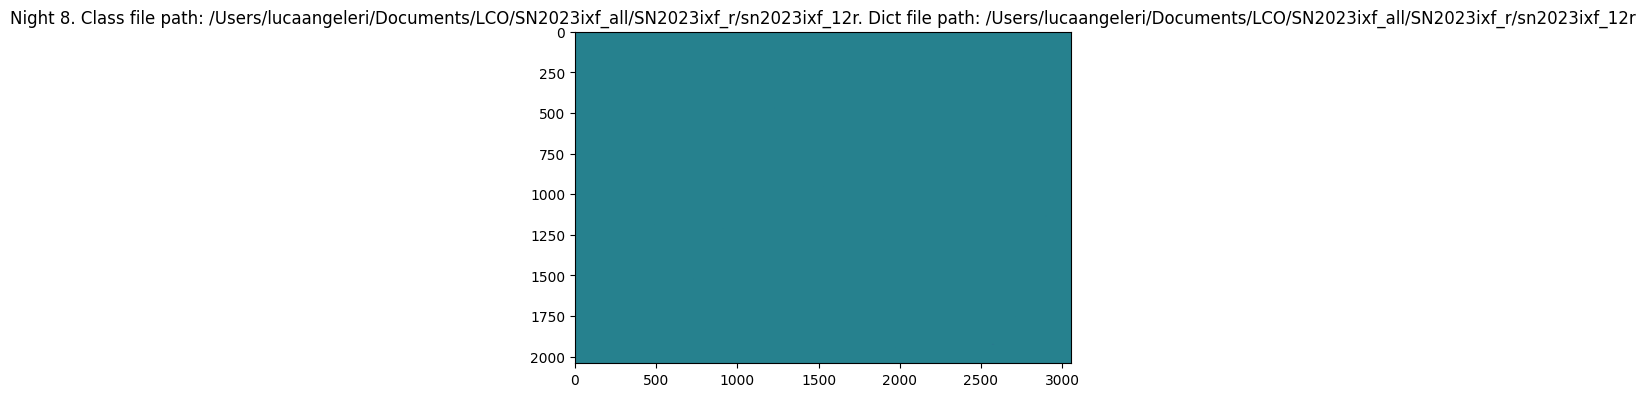

<class 'numpy.dtype[float32]'> <class 'numpy.dtype[float32]'>
0.00030791943 538.9375 -825.6719


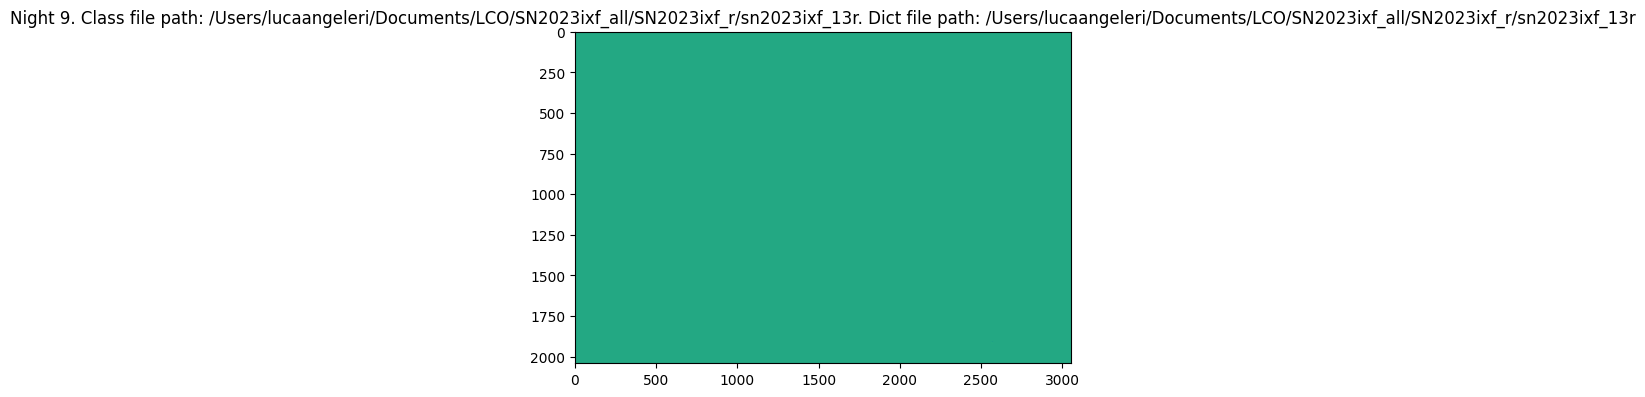

In [67]:
print(f"Class version: {len(Sets)} nights. Dict version: {len(data)} nights")

for run in range(0, len(Sets)):
    #print(f"Class WCS: {Sets[run].wcs}. Dict WCS: {data[run]['WCS']}")
    residual =  np.subtract(Sets[run].template, data[run]['template'])
    print(type(Sets[run].template.dtype), type(data[run]['template'].dtype))
    if np.mean(residual) != 0:
        print(np.mean(residual), np.max(residual), np.min(residual))
        plt.imshow(residual, cmap = 'viridis')
        plt.title(f"Night {Sets[run].obs_night}. Class file path: {Sets[run].path}. Dict file path: {data[run]['directory']}")
        plt.show()

In [64]:
for i in range(0, len(data)):
    print(f'night; {i}')
    class_images = Sets[i].aligned_images
    dict_images = data[i]['images']
    for c, image in enumerate(dict_images):
        res = np.subtract(image, class_images[c])
        if np.mean(res) != 0:
            print(f"Dict: Data {data[i]['run']}")
            print(f"Class Night: {i}, Class Frame number: {c}. Dict Night: {data[i]['run']}, Dict Frame Number: {c}")
            print('\n')
            print(f"Class: {sorted(glob.glob(Sets[i].path + '/*'))[c]}. Dict: {sorted(glob.glob(data[i]['directory'] + '/*'))[c]}")
            print('\n')
            print(f"Class Alignment: {sorted(glob.glob(Sets[i].path + '/*'))[0]}. Dict Alignment: {sorted(glob.glob(data[i]['directory'] + '/*'))[0]}")
            print("########")
        #plt.imshow(res, cmap= 'viridis')
        #plt.show()

night; 0
night; 1
night; 2
night; 3
night; 4
night; 5
night; 6
Dict: Data 6
Class Night: 6, Class Frame number: 2. Dict Night: 6, Dict Frame Number: 2


Class: /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_10r/tfn0m410-kb24-20230624-0120-e91.fits.fz. Dict: /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_10r/tfn0m410-kb24-20230624-0120-e91.fits.fz


Class Alignment: /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_10r/tfn0m410-kb24-20230624-0118-e91.fits.fz. Dict Alignment: /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_10r/tfn0m410-kb24-20230624-0118-e91.fits.fz
########
night; 7
night; 8
Dict: Data 8
Class Night: 8, Class Frame number: 1. Dict Night: 8, Dict Frame Number: 1


Class: /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_12r/tfn0m410-kb24-20230706-0074-e91.fits.fz. Dict: /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_12r/tfn0m410-kb24-20230706

In [74]:
for night in data:
    print(len(night['images']), night['directory'], night['run'])

25 /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_02r 0
25 /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_03r 1
25 /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_06r 2
25 /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_07r 3
25 /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_08r 4
25 /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_09r 5
25 /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_10r 6
25 /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_11r 7
25 /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_12r 8
25 /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_13r 9


In [75]:
for night in Sets:
    print(len(night.aligned_images), night.path, night.obs_night)

25 /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_02r 0
25 /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_03r 1
25 /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_06r 2
25 /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_07r 3
25 /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_08r 4
25 /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_09r 5
25 /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_10r 6
25 /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_11r 7
25 /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_12r 8
25 /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_13r 9
